# Análise de Sentimentos

Neste notebook utilizaremos técnicas de embedding para fazer a análise de sentimentos do títulos

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn import metrics
import seaborn as sns; sns.set()
import tensorflow_hub as hub
np.random.seed(1082141) 
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [6]:
## Função que plota a similaridade entre as features
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [7]:
def readBase(n = None):
	training = pd.read_csv('dataset/train.csv')
	if(n):
		training = training.sample(n)
	#Aplica strip em todas as colunas do dataframe
	training = training.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
	# Todas as colunas que tiverem em branco ficam com NaN
	training = training.replace(r'^\s*$', np.nan, regex=True)
	# Remove todos os NaN da tabela
	training = training.dropna()
	# Fazendo a separação entre treino e validação utilizando o train_test_split 
	# Utilizamos somento as colunas title1_en title2_en
	df_train, df_val = train_test_split(training[['title1_en', 'title2_en', 'label']], test_size=0.2, shuffle=True)
	x_train, x_val = df_train[['title1_en', 'title2_en']], df_val[['title1_en', 'title2_en']]
	y_train, y_val = df_train['label'], df_val['label']
	return x_train, y_train, x_val, y_val

In [8]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(10, 8))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False) 

## Carregando a base

In [9]:
x_train, y_train, x_val, y_val = readBase(10000)

## Usando o embedding como input do classificador

In [13]:
titulos = x_train[['title1_en', 'title2_en']].head(5)
titulos

,title1_en,title2_en
14424,"A 40 -year-old man with kidney asthenia, eatin...","This thing is strong, cancer prevention is a t..."
178852,This is to announce the rhythm of the relation...,The revelation of Zhang Yingxing's love affair?
87536,Major readjustments in poverty alleviation pol...,"The best ""fruit timetable"", this eating most h..."
220345,Zhu Gu-wen is going to quit the entertainment ...,David Chu announced that he quit the entertain...
60288,Chicken BaiFeng pills give patients a healthy ...,Wuhu Baihuifu pill - the first choice of Chine...


In [102]:
titulos.to_numpy()

array([['Wanwan returned, what situation, unexpectedly can compete with the leader of the baby!',
        'Quivering was blocked, the trumpet was pulled back in one night to collect 200,000, netizens: crazy money for money'],
       ['Stock market heroines can not talk about stock-selling secrets, easy to learn, each accurate purchase at the bull stockings ignition point.',
        "One article reads declarer's mouth language secret, the cattle stock is more grasp!"],
       ['eating instant noodles, five major hazards, possibly carcinogenic to humans.',
        "Master Kang's instant noodle contains carcinogenic substances, please don't eat it"],
       ['Shanghai Lujiazui New Landmark: Cobra Building',
        'Zhu Xun, 45, had a bid farewell to CTV for cancer, and her husband was a CCTV celebrity and went into politics'],
       ['Microcredit is about to go offline. Does it affect you?',
        'Fake! Weixin dismisses rumors, denies that will shut down the website page to register'

In [103]:
messages = titulos.to_numpy().ravel()
messages

array(['Wanwan returned, what situation, unexpectedly can compete with the leader of the baby!',
       'Quivering was blocked, the trumpet was pulled back in one night to collect 200,000, netizens: crazy money for money',
       'Stock market heroines can not talk about stock-selling secrets, easy to learn, each accurate purchase at the bull stockings ignition point.',
       "One article reads declarer's mouth language secret, the cattle stock is more grasp!",
       'eating instant noodles, five major hazards, possibly carcinogenic to humans.',
       "Master Kang's instant noodle contains carcinogenic substances, please don't eat it",
       'Shanghai Lujiazui New Landmark: Cobra Building',
       'Zhu Xun, 45, had a bid farewell to CTV for cancer, and her husband was a CCTV celebrity and went into politics',
       'Microcredit is about to go offline. Does it affect you?',
       'Fake! Weixin dismisses rumors, denies that will shut down the website page to register'],
      dtype

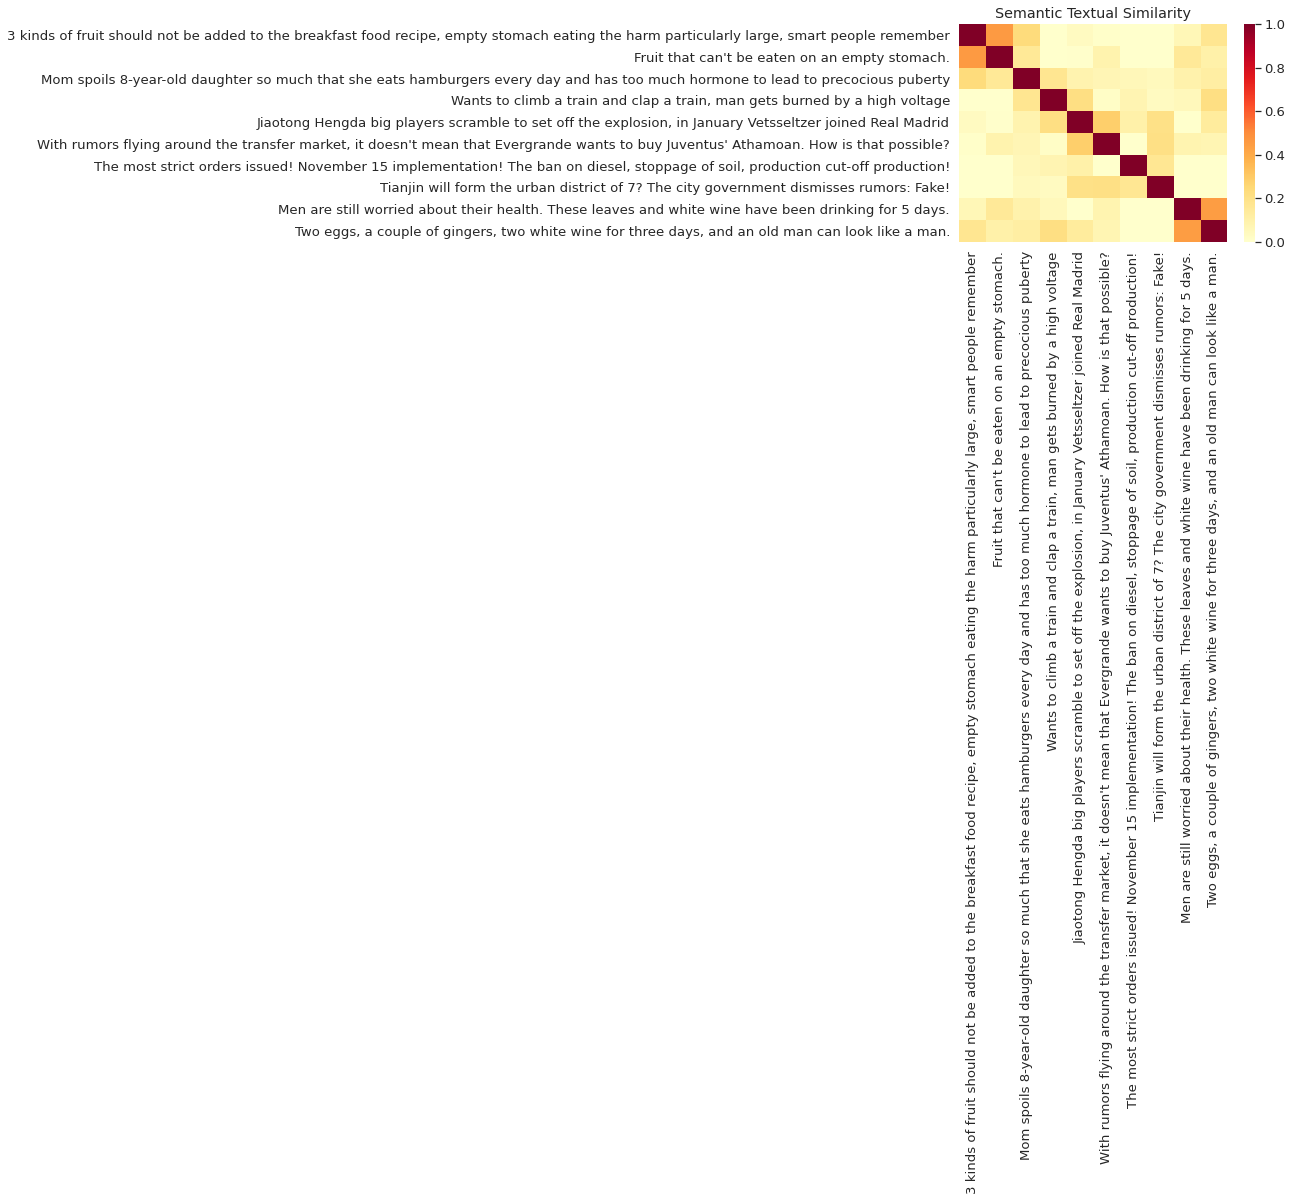

In [33]:
run_and_plot(messages)

In [40]:
def combine(a, b, strategy='concate'):	
	if strategy == 'concate':
		return np.concatenate((a,b), axis=1)
	if strategy == 'sum':
		return e1+e2 
	if strategy == 'mul':
		return e1*e2 
	if strategy == 'abs':
		return abs(e1-e2)
	if strategy == 'pow':
		return (e1-e2)**2 
	raise NameError('parametro strategy errado')
	

In [33]:
embed_x_train_title1 = embed(x_train['title1_en'])
embed_x_train_title2 = embed(x_train['title2_en'])

In [38]:
embed_x_train_title1

<tf.Tensor: shape=(8000, 512), dtype=float32, numpy=
array([[-0.03640358, -0.00375808,  0.0419108 , ...,  0.06041262,
        -0.0735471 ,  0.02070547],
       [ 0.01330109,  0.01359248,  0.03122668, ..., -0.03371187,
        -0.01598973, -0.0103252 ],
       [ 0.00762041, -0.0116044 ,  0.03274025, ...,  0.04834611,
        -0.01662391, -0.04755792],
       ...,
       [ 0.03848439,  0.00537275,  0.07844051, ...,  0.05330671,
         0.03195841, -0.07229953],
       [-0.01640774, -0.0837426 , -0.04680288, ..., -0.02427743,
        -0.07086049, -0.02160558],
       [-0.01556793, -0.04122853, -0.05910791, ..., -0.03788796,
        -0.00606087, -0.04283469]], dtype=float32)>

In [42]:
x_train_embed = combine(embed_x_train_title1, embed_x_train_title2, 'concate')

In [43]:
x_train_embed.shape

(8000, 1024)

In [36]:
embed_x_val_title1 = embed(x_val['title1_en'])
embed_x_val_title2 = embed(x_val['title2_en'])

In [37]:
x_val_embed = combine(embed_x_val_title1, embed_x_val_title2)
x_val_embed.shape

TensorShape([2000, 512])

In [24]:
## aplicando o smoteenn
resampler = SMOTEENN(sampling_strategy="not minority")
x_train_resampled, y_train_resampled = resampler.fit_resample(x_train_embed, y_train)
x_train_resampled

array([[ 0.00851213, -0.00058541,  0.00782903, ..., -0.03083834,
         0.0402785 ,  0.04804949],
       [ 0.01487079, -0.03267263, -0.03186188, ..., -0.02717723,
        -0.07033493,  0.04252966],
       [-0.06544372, -0.08164176, -0.03606014, ..., -0.04443668,
         0.02400461, -0.01277013],
       ...,
       [ 0.03540841, -0.01543167, -0.06180485, ..., -0.00662683,
        -0.08371645,  0.05572135],
       [-0.06897488,  0.0194234 , -0.01691803, ...,  0.01257011,
         0.00132994, -0.04955628],
       [ 0.03894116,  0.01645903,  0.0457451 , ...,  0.01362486,
         0.02054016,  0.02084238]], dtype=float32)

In [26]:
label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_val = label_enc.transform(y_val)
label_enc.classes_

array(['agreed', 'disagreed', 'unrelated'], dtype=object)

In [28]:
# Random Forest com SMOTEENN
clf = RandomForestClassifier(
    oob_score=True, 
    n_jobs=-1, 
    class_weight='balanced'
)

grid_clf_values = {'max_depth': [150], 'n_estimators': [800]}
grid_clf = GridSearchCV(clf, param_grid = grid_clf_values, cv=3, scoring = 'balanced_accuracy', n_jobs = -1)

grid_clf.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True),
             n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150],
                         'n_estimators': [300, 600, 800]},
             scoring='balanced_accuracy')

In [31]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_clf.best_params_, grid_clf.best_score_))

Melhores parametros encontrados {'max_depth': 150, 'n_estimators': 800} com score de 0.8246


Accuracy: 0.324
Accuracy (balanced): 0.451


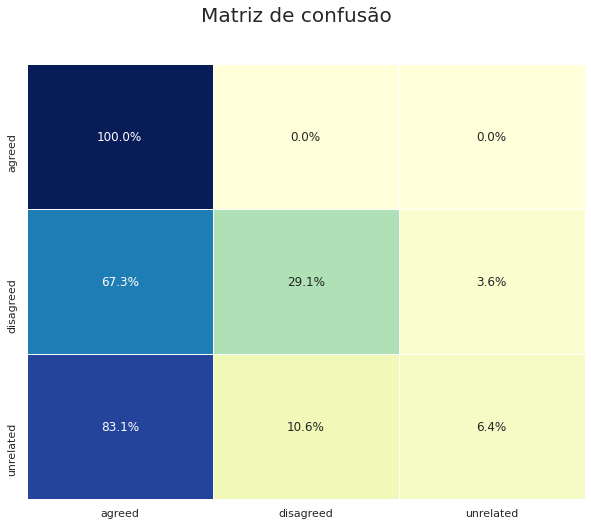

In [30]:
evaluate(y_val, grid_clf.predict(x_val_embed), grid_clf.predict_proba(x_val_embed), labels=label_enc.classes_)